__временные ряды и рекурентная сеть LSTM__

Евгений Борисов esborisov@sevsu.ru

Дмитрий Макаров Временные ряды
https://www.dmitrymakarov.ru/intro/time-series-20/

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
np.set_printoptions(precision=2)

# загружаем данные

https://drive.google.com/file/d/1KE4cPt0l4vSm_OzuPNCf64BxMG_fygFL/view?usp=share_link

In [2]:
# читаем данные

url='https://drive.google.com/uc?id=1KE4cPt0l4vSm_OzuPNCf64BxMG_fygFL'

cols = ['year','month']

df = pd.read_csv(url,sep=';').convert_dtypes()
display(len(df))
display(df.info())
cols = sorted(set(df.columns) - set(['year','month']))
display(df[cols].describe().T)
display(df.sample(3))

706

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          706 non-null    Int64  
 1   month         706 non-null    Int64  
 2   decimal_date  706 non-null    Float64
 3   average       706 non-null    Float64
 4   interpolated  706 non-null    Float64
dtypes: Float64(3), Int64(2)
memory usage: 31.2 KB


None

,count,mean,std,min,25%,50%,75%,max
average,706.0,347.831232,51.852378,-99.99,328.055,349.75,373.1625,407.7
decimal_date,706.0,1987.583333,16.995744,1958.208,1972.89575,1987.5835,2002.271,2016.958
interpolated,706.0,352.037592,26.198294,312.66,328.1375,349.75,373.1625,407.7


,year,month,decimal_date,average,interpolated
605,2008,8,2008.625,384.09,384.09
192,1974,3,1974.208,331.48,331.48
369,1988,12,1988.958,351.41,351.41


In [3]:
df['dt'] = pd.to_datetime( df['year'].astype(str) + '-' + df['month'].astype(str)+ '-01' )
df = df.set_index('dt')
df[['interpolated']]

,interpolated
dt,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.5
1958-06-01,317.1
1958-07-01,315.86
...,...
2016-08-01,402.25
2016-09-01,401.03
2016-10-01,401.57


array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>]], dtype=object)

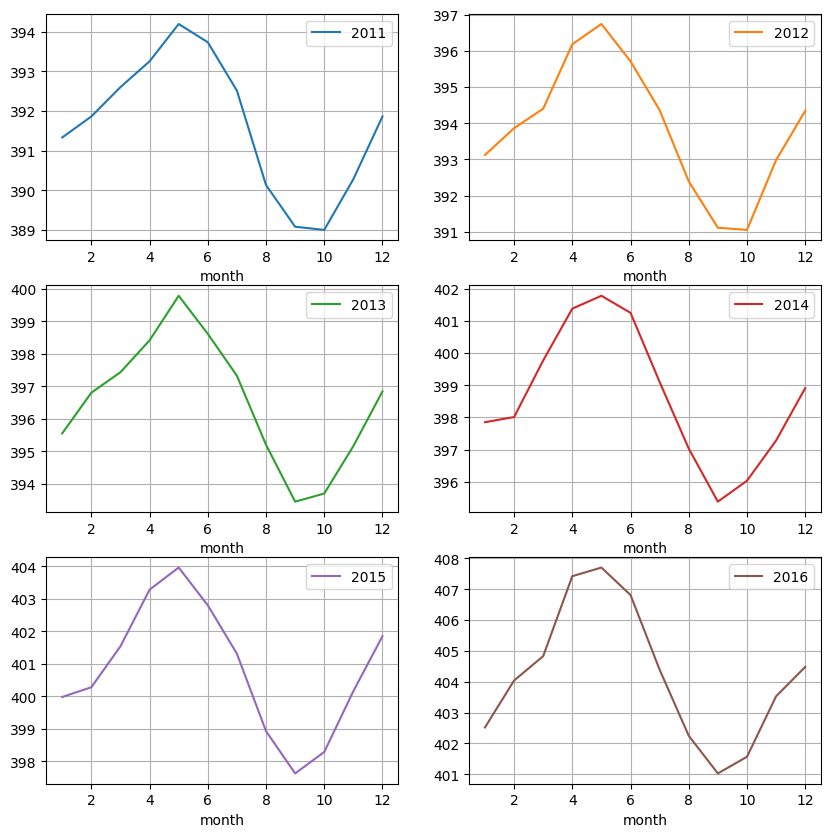

In [4]:
pd.pivot_table(
    df.query('year>2010').reset_index(),
    index='month', columns='year', values='interpolated'
).plot(subplots=True,figsize=(10,10),grid=True,layout=(3,2), sharex=False, )

<Axes: xlabel='dt'>

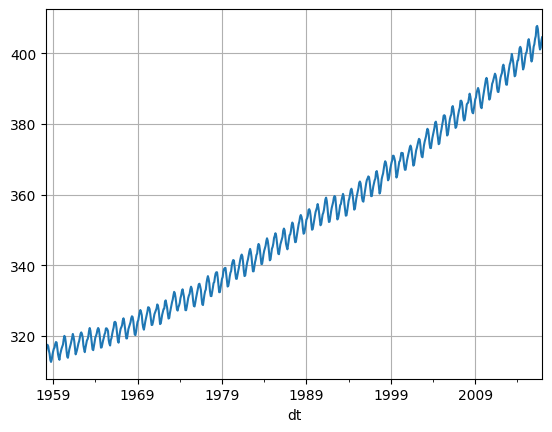

In [5]:
# имеем нестационарный временной ряд
df['interpolated'].plot(grid=True)

In [6]:
from statsmodels.tsa.stattools import adfuller 

In [7]:
# проверка ряда на стационарность
res = adfuller( df['interpolated'].dropna()) 
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1]) 

Augmented Dickey-Fuller Statistic: 4.817876
p-value: 1.000000


In [8]:
# дифференцирование ряда - переход к попарным разницам:  dy_t = ( y_t - y_t-1 )
# преобразует ряд в стационарный
df['d_interpolated'] =  df['interpolated'].diff() # ( df['interpolated'] - df['interpolated'].shift(1) )

In [9]:
# проверка ряда на стационарность после применения дифференцирования
res = adfuller( df['d_interpolated'].dropna()) 
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1]) 

Augmented Dickey-Fuller Statistic: -5.116784
p-value: 0.000013


<Axes: xlabel='dt'>

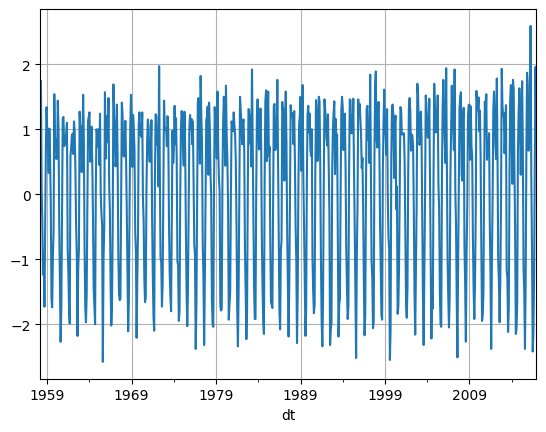

In [10]:
df['d_interpolated'].plot(grid=True)

In [11]:
# pd.pivot_table(
#         df.query('year>2010').reset_index(),
#         index='month', columns='year', values='d_interpolated'
#     ).plot(subplots=True,figsize=(10,10),grid=True,layout=(3,2), sharex=False, )

<Axes: xlabel='dt'>

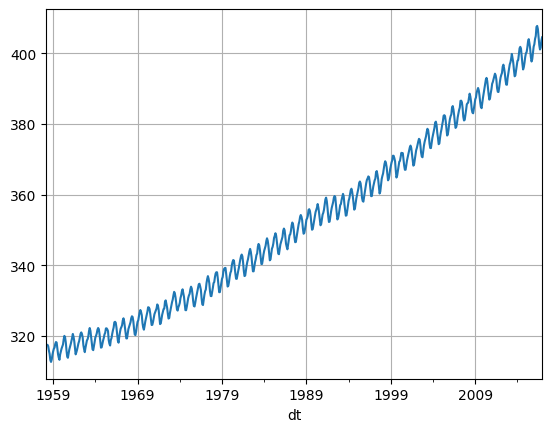

In [12]:
# обратное преобразование:  y_t = dy_t + y_t-1
df['interpolated_'] = ( df['d_interpolated'] + df['interpolated'].shift(1) )
df['interpolated_'].plot(grid=True)

будем предсказывать изменение значения d_interpolated

## подготовка датасета

In [13]:
df[['interpolated','d_interpolated']].describe().T

,count,mean,std,min,25%,50%,75%,max
interpolated,706.0,352.037592,26.198294,312.66,328.1375,349.75,373.1625,407.7
d_interpolated,705.0,0.125915,1.225752,-2.58,-0.97,0.55,1.14,2.59


In [14]:
# OHE код месяца
month_bin = np.eye( df['month'].max(), dtype=np.float32 )[ np.array(df['month']-1, dtype=np.uint8) ]

# изменения interpolated
d_interpolated = np.array( df[['d_interpolated']].fillna(0.), dtype=np.float32 )

# собираем вместе
data = np.hstack([ month_bin, d_interpolated ])

n_features = data.shape[1] # размер вектора признаков для модели

display(data.shape, n_features)

(706, 13)

13

In [15]:
data

array([[0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.74],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.05],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.54],
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 1.96],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.95]], dtype=float32)

In [16]:
# разбиваем на тестовый и учебный по временной отметке
year_split = 2010
f = np.array( df['year']>year_split, dtype=bool )
data_train, data_test = data[~f,:], data[f,:]
display( data_train.shape, data_test.shape )

(634, 13)

(72, 13)

In [17]:
del data

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [19]:
# формируем датасет 

#  вход  - история изменений за seq_len месяцев
#  выход - прогноз изменения на следующий месяц
#
#  [ 
#     [ 
#        <код месяца, разница с прошлым месяцем>, 
#        <код месяца, разница с прошлым месяцем>,
#          ....
#        <код месяца, разница с прошлым месяцем> 
#     ], 
#     <прогноз изменения на следующий месяц> 
# ] 

class SeqDataset(Dataset):
    
    def __init__(self, data, seq_len):
        self._seq_len = seq_len
        self._data = data.astype(np.float32)

    def __len__(self): 
        return len(self._data) - self._seq_len

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(
                np.vstack([ # входная последовательность : код месяца и значение d_interpolated
                    # обнуляем в последовательности первое значение d_interpolated
                    np.hstack([ self._data[idx,:-1],[0.] ]), 
                    self._data[idx+1:idx+self._seq_len] 
                ])
            ),
            torch.FloatTensor( self._data[idx+self._seq_len,[-1]] ),            
        )

# строим модель

In [20]:
class Model(nn.Module):
    
    def __init__(self, n_features= n_features, hidden_dim=128):
        super().__init__()
        self._rnn = nn.GRU( input_size=n_features, hidden_size=hidden_dim, batch_first=True) # рекуррентный слой
        self._linear = nn.Linear(hidden_dim, 1) # выходной (линейный) слой

    def forward(self,x):
        _, hidden = self._rnn(x) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self._linear(hidden) # считаем выход сети
        return out

In [21]:
# class Model(nn.Module):
    
#     def __init__(self, n_features= n_features, hidden_dim=128):
#         super().__init__()
#         self._rnn0 = nn.LSTM( input_size=n_features, hidden_size=hidden_dim, batch_first=True) 
#         self._rnn1 = nn.GRU( input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
#         self._linear = nn.Linear(hidden_dim, 1) # выходной (линейный) слой

#     def forward(self,x):
#         o, (_,_) = self._rnn0(x) # обрабатываем входную последовательность
#         _, hidden = self._rnn1(o) # обрабатываем входную последовательность
#         hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
#         out = self._linear(hidden) # считаем выход сети
#         return out

# обучаем модель

In [22]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )

model = Model().to(device)

device(type='cuda', index=0)

In [23]:
criterion =  nn.MSELoss() # ф-ция потери
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # метод оптимизации

In [24]:
%%time

seq_len = 6 # глубина истории (месяцев)

loss_history = [] # значения ф-ции потери

n_epoch = 1024*8 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,y in DataLoader( SeqDataset(data_train,seq_len=seq_len), batch_size=len(data_train)//2, shuffle=True): 
        out = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( y.to(device),out ) # вычисляем значение ф-ции потери
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
        
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
        

  0%|          | 0/8192 [00:00<?, ?it/s]

CPU times: user 2min 54s, sys: 429 ms, total: 2min 54s
Wall time: 2min 55s


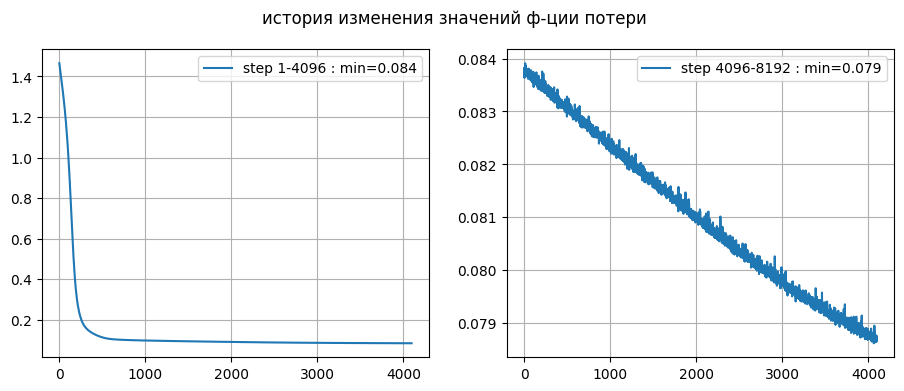

In [25]:
from matplotlib import pyplot as plt

# разделим график изменения потери на несколько частей для лучшего представления масштаба значений

step_split = n_epoch//2

fig,ax = plt.subplots(1,2,figsize=(11,4))

fig.suptitle('история изменения значений ф-ции потери')

ax[0].plot(loss_history[:step_split],
           label='step 1-%i : min=%.3f'%(step_split,min(loss_history[:step_split])))
ax[0].grid()
ax[0].legend()

ax[1].plot(loss_history[step_split:],
           label='step %i-%i : min=%.3f'%(step_split,n_epoch,min(loss_history[step_split:])))
ax[1].grid()
ax[1].legend()

# тестируем

In [26]:
# считаем loss на тесте
display( len(data_test) ) # размер датасета

# вычисляем значение ф-ции потери
with torch.set_grad_enabled(False):
    for x,y in DataLoader(SeqDataset(data_test,seq_len=seq_len), batch_size=len(data_test), shuffle=False): 
        loss_test = criterion( y.to(device), model(x.to(device)) ).item() 
        
display(loss_test)  

72

0.1466311812400818

## строим прогноз

In [27]:
# возьмем первую последовательность изменений длинны {seq_len} месяцев с {year_split} года
# посчитаем прогноз изменения на следующий месяц
# и на его основе авторегресиионным способом посчитаем прогноз для следующих месяцев

In [28]:
display(seq_len, year_split )

6

2010

In [29]:
# будем брать коды месяцев из тестового датасета
# подставлять туда полученные от модели значения прогноза изменений
data_test_ = data_test 

with torch.set_grad_enabled(False): 
    for idx in range(len(data_test)-seq_len): # будем двигать окно размера seq_len по месяцам
        x = data_test_[idx:idx+seq_len]  # входная последовательность 
        data_test_[idx+seq_len,-1] = model( # считаем прогноз и пишем его в таблицу результата
                torch.FloatTensor(x[np.newaxis,:]).to(device)
            ).cpu().numpy().flatten()[0]

In [30]:
df_test = df[ df['year']>year_split ][['interpolated']] # данные начиная с {year_split} года

# начальное значение на основе, которого будем рассчитывать прогноз
interpolated_pred = [ df_test.iloc[seq_len-1].values[0] ]

# авторегресиионным способом посчитаем прогноз для следующих месяцев
# с помощью полученных от модели значений изменения по месяцам
for d in data_test_[seq_len:,-1]:
    interpolated_pred.append(interpolated_pred[-1]+d)

<Axes: xlabel='dt'>

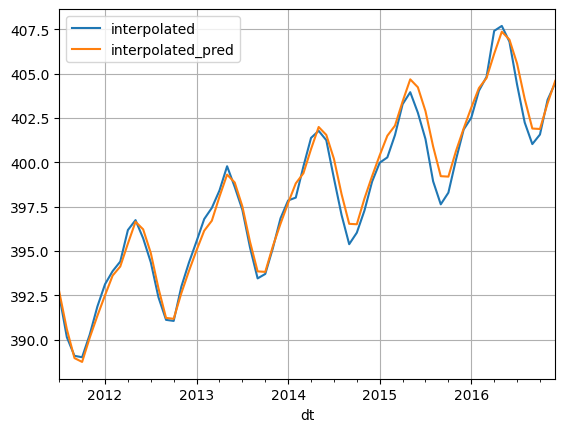

In [31]:
# добавим прогноз в исходную таблицу данных 
df_test['interpolated_pred'] = [0]*(len(df_test)-len(interpolated_pred)) + interpolated_pred

# и нарисуем сравнительный график
df_test[seq_len:].plot(grid=True)